In [1]:
from ecoevocrm.consumer_resource_system import *
import ecoevocrm.utils as utils
import ecoevocrm.viz as viz
import ecoevocrm.coarse_graining as cg

In [2]:
import matplotlib.pyplot as plt

In [3]:
import cProfile
import pstats
%load_ext line_profiler

--------

### Set the number of resources

In [4]:
L = 16

### Define the ancestral phenotype (traits vector)

In [5]:
anc_phenotype = utils.random_matrix(shape=(1, L), mode='binomial')

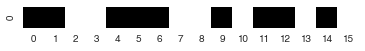

In [6]:
viz.matrix_plot(anc_phenotype)

### Define the system biochemistry (trait/resource interactions)

In [7]:
J = utils.random_matrix((L, L), 'tikhonov_sigmoid')

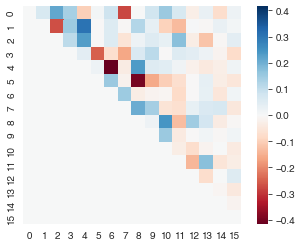

In [8]:
viz.matrix_plot(J)

In [44]:
np.sum(J)

0.6371885844832176

### Parameterize and instantiate the Consumer-Resource System

In [10]:
anc_system = ConsumerResourceSystem(sigma=anc_phenotype, 
                                    b=1, 
                                    k=1e10,
                                    c=0.1, chi=0.5, J=J, 
                                    mu=1e-10,
                                    resource_consumption_mode='fast_resource_eq',
                                    resource_inflow_mode='none',
                                    threshold_min_rel_abundance=1e-6,
                                    N_init=1, R_init=1)

### Simulate dynamics

In [11]:
# just to pre-compile the dynamics njit function
# anc_system.dynamics(*((0,) + (np.zeros(L+L+1),) + anc_system.get_params()))

In [12]:
# anc_system.run(T=1000)

In [13]:
# %lprun -f anc_system.dynamics anc_system.run(T=1000)
# %lprun -f anc_system.handle_mutation_event anc_system.run(T=1000)

In [14]:
profiler = cProfile.Profile()
# %lprun -f anc_system.dynamics profiler.runcall(anc_system.run)
# %lprun -f ConsumerResourceSystem.growth_rate profile.runcall(anc_system.run)
# %lprun -f anc_system.event_low_abundance profiler.runcall(anc_system.run)
# %lprun -f TypeSet.add_type profiler.runcall(anc_system.run)
# %lprun -f TypeSet.generate_mutant_set profiler.runcall(anc_system.run)

%lprun -f anc_system.add_type profiler.runcall(anc_system.run)

Timer unit: 1e-06 s

Total time: 155.251 s
File: /Users/ryan/Dropbox/Projects/ResearchProjects/eco-evo-crm/ecoevocrm/src/ecoevocrm/consumer_resource_system.py
Function: add_type at line 707

Line #      Hits         Time  Per Hit   % Time  Line Contents
   707                                               def add_type(self, type_set=None, abundance=0, sigma=None, b=None, k=None, eta=None, l=None, g=None, c=None, chi=None, mu=None, index=None, parent_index=None, parent_id=None):
   708       750       4279.0      5.7      0.0          abundance      = utils.treat_as_list(abundance)
   709       750        894.0      1.2      0.0          new_type_idx   = index if index is not None else self.type_set.num_types # default to adding to end of matrices
   710       750        724.0      1.0      0.0          orig_num_types = self.type_set.num_types
   711                                                   #----------------------------------
   712       750     342103.0    456.1      0.2     

In [15]:
ps = pstats.Stats(profiler)
ps.sort_stats('cumtime')
ps.print_stats()

         6427383 function calls (6427370 primitive calls) in 203.880 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    1.055    1.055  203.893  203.893 /Users/ryan/Dropbox/Projects/ResearchProjects/eco-evo-crm/ecoevocrm/src/ecoevocrm/consumer_resource_system.py:185(run)
     8065    0.680    0.000  162.424    0.020 /Users/ryan/Dropbox/Projects/ResearchProjects/eco-evo-crm/ecoevocrm/src/ecoevocrm/consumer_resource_system.py:534(handle_mutation_event)
      750   14.124    0.019  155.260    0.207 /Users/ryan/Dropbox/Projects/ResearchProjects/eco-evo-crm/ecoevocrm/src/ecoevocrm/consumer_resource_system.py:707(add_type)
     8334  141.162    0.017  141.476    0.017 /usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:5143(insert)
     8065    2.306    0.000   29.883    0.004 /usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py:156(solve_ivp)
    38154    0.243    0.000   20.507    0.001 /

### Visualize results

In [16]:
type_colors = viz.color_types_by_phylogeny(anc_system.type_set, apply_palette_depth=1)

<AxesSubplot:>

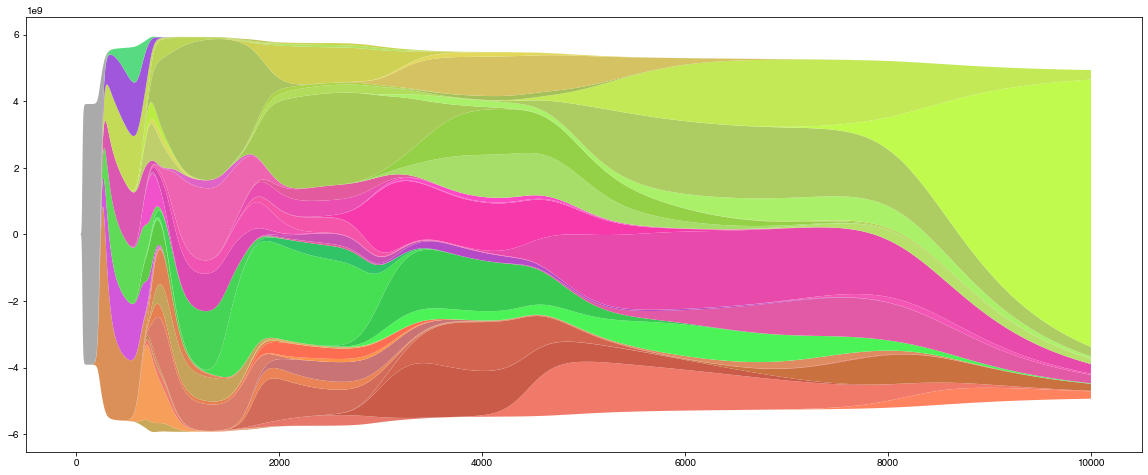

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
viz.stacked_abundance_plot(anc_system, ax=ax, type_colors=type_colors)

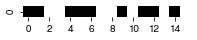

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(3, 12))
viz.matrix_plot(anc_phenotype, ax=ax)

In [19]:
# fig, ax = plt.subplots(1, 1, figsize=(3, 12))
# viz.matrix_plot(anc_system.type_set.sigma, ax=ax)

In [20]:
# anc_system.extant_type_indices

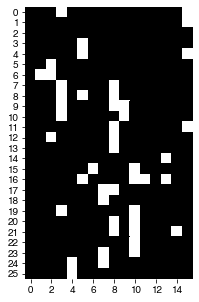

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(3, 12))
viz.matrix_plot(anc_system.get_extant_type_set().sigma, ax=ax)

In [22]:
# fig, ax = plt.subplots(1, 1, figsize=(3, 12))
# viz.matrix_plot(anc_system.extant_mutant_set.sigma, ax=ax)

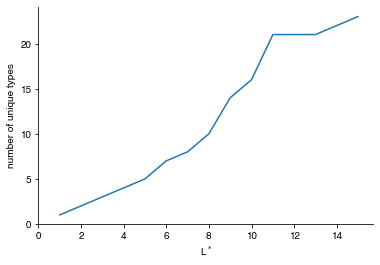

In [23]:
viz.Lstar_types_plot(anc_system)

In [24]:
N_end = anc_system.N_series[:,-1]
np.count_nonzero((N_end > 0) & (N_end < 1e4))

0

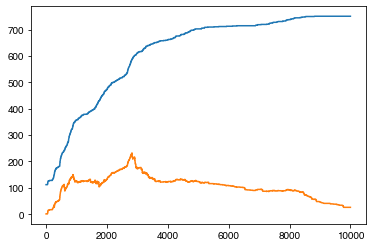

In [25]:
a = (anc_system.N_series > 0).argmax(axis=1)
n = []
for t_idx in range(anc_system.t_series.shape[0]):
    n.append(np.count_nonzero(a <= t_idx)) 
plt.plot(anc_system.t_series, n)
plt.plot(anc_system.t_series, (anc_system.N_series > 0).sum(axis=0))

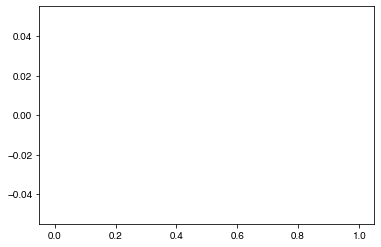

In [26]:
plt.hist(anc_system.N_series[(anc_system.N_series[:,-1]>0)&(anc_system.N_series[:,-1]<1e4),-1], bins=100)
# plt.xlim((0,100))
plt.show()

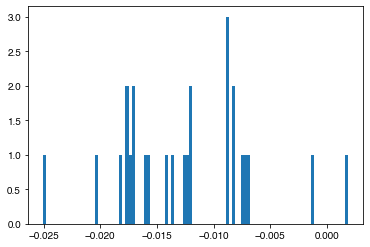

In [27]:
r = ConsumerResourceSystem.growth_rate(anc_system.N()[:, np.newaxis], anc_system.R(), anc_system.type_set.sigma, anc_system.type_set.b, anc_system.type_set.k, anc_system.type_set.eta, anc_system.type_set.l, anc_system.type_set.g, anc_system.type_set.energy_costs, anc_system.resource_set.omega, anc_system.resource_consumption_mode)

plt.hist(r[anc_system.N() > 0] , bins=100)
plt.show()

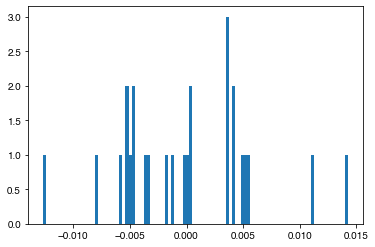

In [28]:
s = r - np.mean(r[anc_system.N() > 0])

plt.hist(s[anc_system.N() > 0] , bins=100)
plt.show()

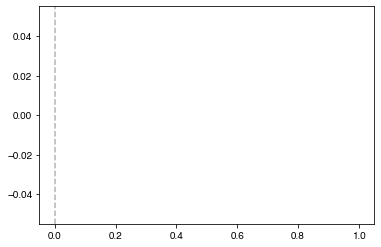

In [29]:
r_lowabd = r[(anc_system.N() > 0) & (anc_system.N() < 1e4)]

plt.hist(r_lowabd, bins=100)
plt.axvline(0, color='k', alpha=0.3, ls='--')
plt.show()

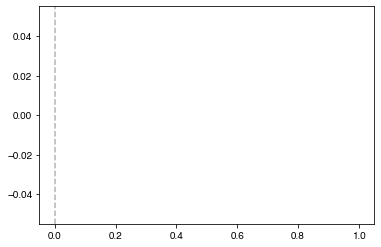

In [30]:
s_lowabd = r[(anc_system.N() > 0) & (anc_system.N() < 1e4)] - np.mean(r[r > 0])

plt.hist(s_lowabd, bins=100)
plt.axvline(0, color='k', alpha=0.3, ls='--')
plt.show()

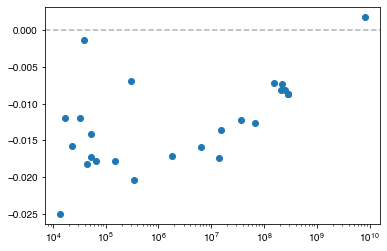

In [31]:
plt.scatter(anc_system.N()[anc_system.N() > 0], r[anc_system.N() > 0])
plt.axhline(0, color='k', alpha=0.3, ls='--')
plt.xscale('log')
plt.show()

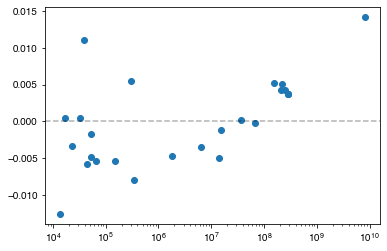

In [32]:
plt.scatter(anc_system.N()[anc_system.N() > 0], s[anc_system.N() > 0])
plt.axhline(0, color='k', alpha=0.3, ls='--')
plt.xscale('log')
plt.show()

In [33]:
anc_system.type_set.sigma.shape

(751, 16)

In [34]:
a = np.where(anc_system.N_series > 0)

In [35]:
anc_system.N()/np.sum(anc_system.N())

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [36]:
anc_system.get_extant_types()


array([ 81, 109, 122, 148, 149, 151, 172, 180, 184, 194, 195, 208, 223,
       224, 331, 339, 351, 395, 409, 489, 622, 630, 647, 663, 684, 694])

In [37]:
1e3/1e10

1e-07

In [38]:
anc_system.type_set.mu.shape

()

In [39]:
anc_system.t_series.shape

(46220,)

In [40]:
anc_system.N_series.shape

(751, 46220)

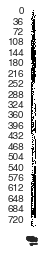

In [41]:
viz.matrix_plot(anc_system.type_set.sigma)

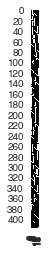

In [42]:
viz.matrix_plot(anc_system.extant_mutant_set.sigma)